In [ ]:
import pandas as pd # загружаем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns

from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore") # Отключаем некритические уведомления

In [ ]:
dfmovies = pd.read_csv('movies.csv')

# **ИЗУЧИМ ДАННЫЕ**

In [ ]:
dfmovies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


# ПОСМОТРИМ НА СПИСОК ФИЛЬМОВ

In [ ]:
dfmovies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


***Посмотрим на уникальные жанры...***

Задача осложняется тем, что к одному фильму может быть указано несколько жанров. Каждую строчку в "жанрах" исходного датафрейма придётся парсить на отдельные слова и считать...

array([<Axes: title={'center': 'frequency'}>], dtype=object)

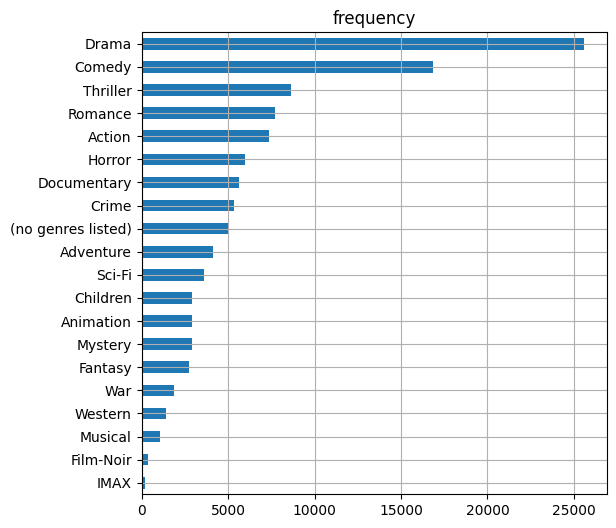

In [ ]:
genresList = []
for i in range (0,len(dfmovies)):
  genresList += (dfmovies['genres'][i].split('|'))
genresList = list(set(genresList))

genreCount = pd.DataFrame(
index = genresList)

uniqueNames = np.unique(dfmovies.genres, return_counts = True)
count = []
for genre in genresList:
  count1 = 0
  for el in uniqueNames[0]:
    ind = np.where(uniqueNames[0] == el)[0][0]
    if genre in el.split('|'):
      count1 += uniqueNames[1][ind]
    else:
      pass
  count.append(count1)

genreCount.insert(0, "frequency", count, True)
genreCount.sort_values(by='frequency').plot(subplots=True,kind='barh', legend = 0, figsize=(6, 6), grid = 1)

***В этом датасете присутствуют строчки с фильмами, к которым не указаны жанры...***

# СЧИТАЕМ РЕЙТИНГИ ФИЛЬМОВ

In [ ]:
dfratings = pd.read_csv('ratings.csv')
dfratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [ ]:
dfratings.head(5)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


***Посмотрим, скольким фильмам поставлены оценки...***

array([<Axes: ylabel='percentile'>], dtype=object)

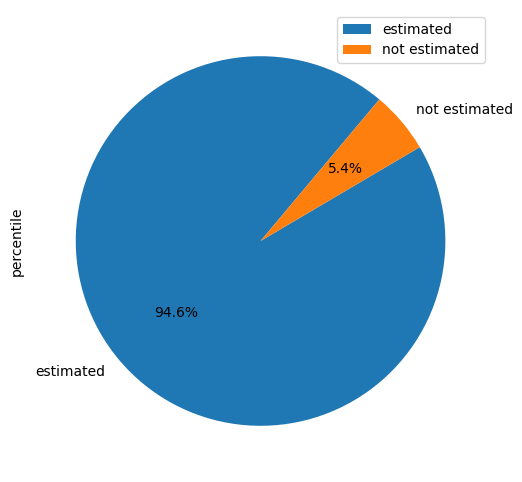

In [ ]:
movIds = dfratings['movieId'].drop_duplicates()
est = movIds.shape[0]
percentile = [est, dfmovies.shape[0]-est]

estimatedFilms = pd.DataFrame({
    'percentile': percentile
},
index = ['estimated', 'not estimated'])

estimatedFilms.plot(subplots=True,kind='pie', figsize=(6, 6),startangle = 50, autopct = '%1.1f%%')

***В этом датасете оценены не все фильмы...***

***Выведем среднюю оценку для каждого пользователя и количество фильмов, которые он оценил...***

In [ ]:
df_meanRating = copy.deepcopy(dfratings)
del df_meanRating['movieId']
del df_meanRating['timestamp']
df_meanRating = df_meanRating.groupby('userId').agg('mean')
df_summ = dfratings['userId'].value_counts()
df_ratingCount = pd.merge(df_meanRating, df_summ, on='userId', how='inner')
df_ratingCount.head(5)

,rating,count
userId,,
1,3.814286,70
2,3.630435,184
3,3.697409,656
4,3.378099,242
5,3.752475,101


***Будем считать, что хороших фильмов больше, чем плохих, потому что плохие фильмы априори никто не хочет спонсировать***

In [ ]:
underEstimating = df_ratingCount[(df_ratingCount['rating']<2) & (df_ratingCount['count']>50)]
underEstimating.head(4) # Пользователи, которые ставят заниженные оценки

,rating,count
userId,,
181,1.835890,652
986,1.982906,351
1175,1.726115,157
1484,1.052934,869


In [ ]:
upperEstimating = df_ratingCount[(df_ratingCount['rating']>4.5) & (df_ratingCount['count']>150)]
upperEstimating.head(4) # Пользователи, которые ставят завышенные оценки

,rating,count
userId,,
240,4.734694,196
445,4.578125,192
865,4.661731,439
1167,4.754545,165


***Посмотрим на распределение пользователей по оценкам...***

array([<Axes: title={'center': 'User distribution by mean rating'}>],
      dtype=object)

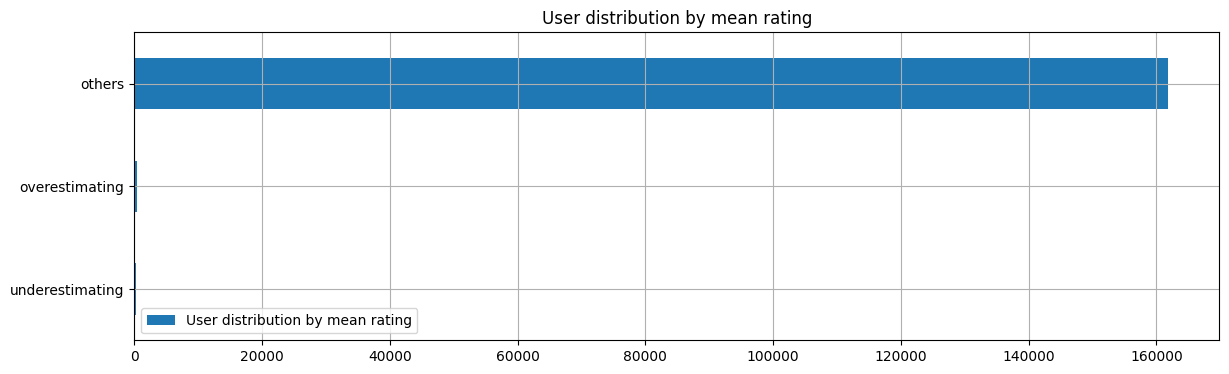

In [ ]:
df_ratingCount_copy = copy.deepcopy(df_ratingCount)
a = df_ratingCount_copy.shape[0]
df_ratingCount_copy = df_ratingCount_copy.drop(underEstimating.index)
df_ratingCount_copy = df_ratingCount_copy.drop(upperEstimating.index)
b = df_ratingCount_copy.shape[0]

percentile = [underEstimating.shape[0], upperEstimating.shape[0], df_ratingCount_copy.shape[0]]

userDistribution = pd.DataFrame({
    'User distribution by mean rating': percentile
},
index = ['underestimating', 'overestimating', 'others'])
userDistribution.plot(subplots=True,kind='barh', figsize=(14, 4), grid='on')

array([<Axes: title={'center': 'User distribution by mean rating'}>],
      dtype=object)

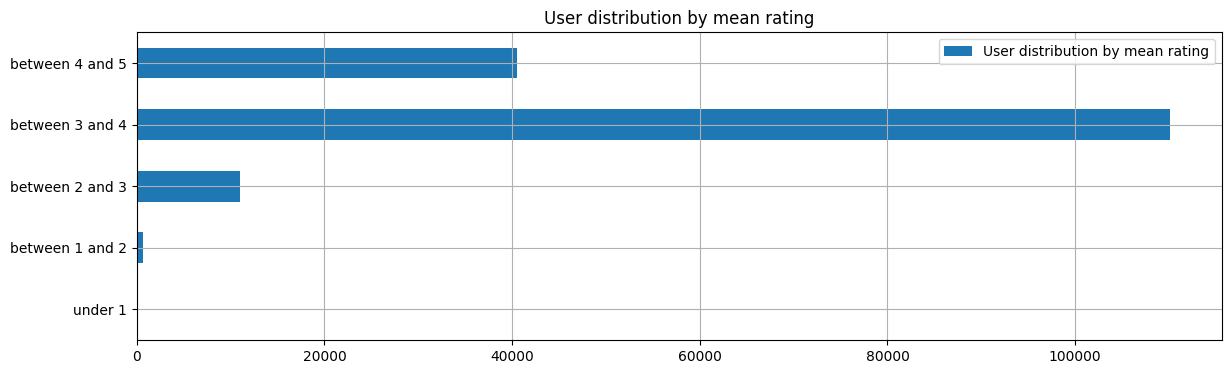

In [ ]:
und1 = df_ratingCount[df_ratingCount['rating']<1]
b1n2 = df_ratingCount[(df_ratingCount['rating']>=1) & (df_ratingCount['rating']<2)]
b2n3 = df_ratingCount[(df_ratingCount['rating']>=2) & (df_ratingCount['rating']<3)]
b3n4 = df_ratingCount[(df_ratingCount['rating']>=3) & (df_ratingCount['rating']<4)]
b4n5 = df_ratingCount[(df_ratingCount['rating']>=4) & (df_ratingCount['rating']<5)]

percentile = [und1.shape[0], b1n2.shape[0], b2n3.shape[0], b3n4.shape[0], b4n5.shape[0]]

movieDistribution = pd.DataFrame({
    'User distribution by mean rating': percentile
},
index = ['under 1', 'between 1 and 2', 'between 2 and 3', 'between 3 and 4', 'between 4 and 5'])
movieDistribution.plot(subplots=True,kind='barh', figsize=(14, 4), grid='on')

***Посмотрим на распределение фильмов по оценкам...***

In [ ]:
df_meanMovieRating = copy.deepcopy(dfratings)
del df_meanMovieRating['userId']
del df_meanMovieRating['timestamp']
df_meanMovieRating = df_meanMovieRating.groupby('movieId').agg('mean')
df_meanMovieRating.head(5)

,rating
movieId,
1,3.893708
2,3.251527
3,3.142028
4,2.853547
5,3.058434


array([<Axes: title={'center': 'Movie distribution by mean rating'}>],
      dtype=object)

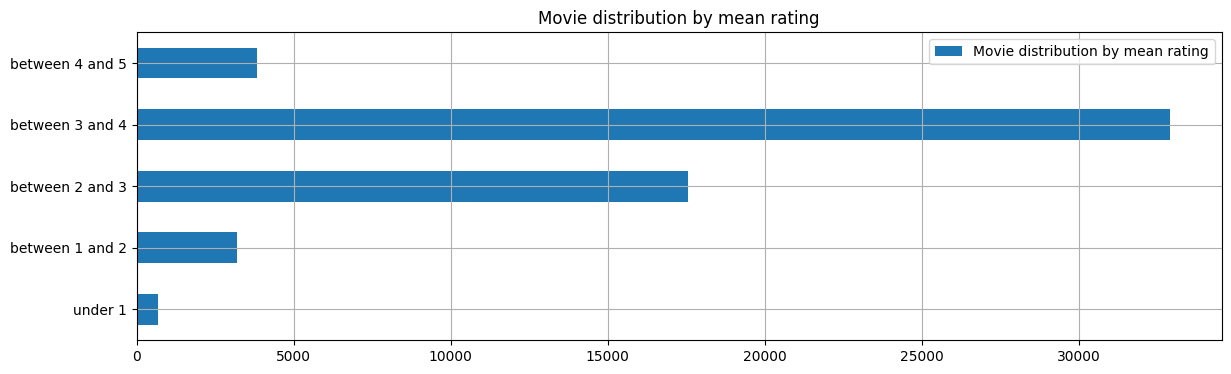

In [ ]:
und1 = df_meanMovieRating[df_meanMovieRating['rating']<1]
b1n2 = df_meanMovieRating[(df_meanMovieRating['rating']>=1) & (df_meanMovieRating['rating']<2)]
b2n3 = df_meanMovieRating[(df_meanMovieRating['rating']>=2) & (df_meanMovieRating['rating']<3)]
b3n4 = df_meanMovieRating[(df_meanMovieRating['rating']>=3) & (df_meanMovieRating['rating']<4)]
b4n5 = df_meanMovieRating[(df_meanMovieRating['rating']>=4) & (df_meanMovieRating['rating']<5)]

percentile = [und1.shape[0], b1n2.shape[0], b2n3.shape[0], b3n4.shape[0], b4n5.shape[0]]

movieDistribution = pd.DataFrame({
    'Movie distribution by mean rating': percentile
},
index = ['under 1', 'between 1 and 2', 'between 2 and 3', 'between 3 and 4', 'between 4 and 5'])
movieDistribution.plot(subplots=True,kind='barh', figsize=(14, 4), grid='on')

# В датасет к фильмам добавим столбец с годом создания фильма

***Снова парсим строки, снова считаем...***

In [ ]:
df_filmYear = pd.DataFrame({
    'movieId':[],
    'year':[]
})

for i in range (0,len(dfmovies)):
  year = []
  year = dfmovies['title'][i].split(' ')
  for w in year:
    if (")" or "(") in w:
      y = w[1:-1]
      try:
        df_filmYear.loc[i] = [dfmovies['movieId'][i], int(y)]
      except:
        y=0
        df_filmYear.loc[i] = [dfmovies['movieId'][i], int(y)]
    else:
      y=0
      df_filmYear.loc[i] = [dfmovies['movieId'][i], int(y)]

percent = df_filmYear[df_filmYear['year']==0].shape[0]/df_filmYear.shape[0]*100
fp = "{:0.2f}".format(percent)
print("Год создания фильма не удалось определить для", df_filmYear[df_filmYear['year']==0].shape[0],"=", fp, "% записей")

Год создания фильма не удалось определить для 572 = 0.92 % записей


***Не для всех фильмов удалось определить год создания...***

In [ ]:
dfmovies1 = pd.merge(dfmovies,df_filmYear, on='movieId', how='inner')

In [ ]:
dfmovies1

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
62418,209157,We (2018),Drama,2018
62419,209159,Window of the Soul (2001),Documentary,2001
62420,209163,Bad Poems (2018),Comedy|Drama,2018
62421,209169,A Girl Thing (2001),(no genres listed),2001


In [ ]:
maxYear = dfmovies1['year'].max(axis=0)
print("Самые свежие фильмы в таблице относятся к следующему году:",maxYear)

Самые свежие фильмы в таблице относятся к следующему году: 2019


# **СОЗДАДИМ НЕЙРОСЕТЬ ДЛЯ ГЕНЕРАЦИИ РЕКОМЕНДАЦИЙ НА ОСНОВЕ ПРЕДПОЧТЕНИЙ КОНКРЕТНОГО ПОЛЬЗОВАТЕЛЯ (*ЗАДАЧА БИНАРНОЙ КЛАССИФИКАЦИИ*)**
*В данной задаче пользователь сам размечает данные на понравившиеся и не понравившиеся, и уже на размеченных данных тренируется нейросеть. После этого нейросеть предлагает пользователю фильмы из тех, которые он ещё не видел.*

*Данный подход предполагает переобучение нейросети всякий раз, когда пользователь отмечает новый фильм как понравившийся или не понравившийся. В реальности переобучение будет происходить каждый десяток таких раз*

# СОЕДИНИМ ТАБЛИЦЫ С ФИЛЬМАМИ И РЕЙТИНГОМ

In [ ]:
mergeddfs = pd.merge(dfmovies1, df_meanMovieRating, on='movieId', how='outer')
mergeddfs.rename(columns={"rating": "mean_rating"}, inplace=True)
mergeddfs.head(5)

,movieId,title,genres,year,mean_rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,3.893708
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3.251527
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,3.142028
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,2.853547
4,5,Father of the Bride Part II (1995),Comedy,1995,3.058434


# СОБЕРЁМ ДАТАСЕТ
21 входных нейронов. 19 отвечают за жанр. Последние отвечают за нормализованный рейтинг и нормализованный год создания

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
coded_genres = labelencoder.fit_transform(genresList)
genre2code = dict(zip(labelencoder.classes_, coded_genres))

dataset = []

for i in range(0,len(mergeddfs)):
  params_of_film = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  GENRES = mergeddfs['genres'][i].split('|')
  for el in genresList:
    if (el in GENRES) and (el != '(no genres listed)'):
      params_of_film[genre2code[el]] = 1
    else:
      pass
  params_of_film[20] = float("{:0.4f}".format(float(mergeddfs['mean_rating'][i])/5)) # рейтинг
  params_of_film[genre2code['(no genres listed)']] = float(mergeddfs['year'][i]/maxYear) # год
  dataset.append(params_of_film)

# "НАЛАЙКАЕМ" СЕБЕ ФИЛЬМОВ ЖАНРА "ADVENTURE"/"COMEDY"/"FANTASY", ВЫПУЩЕННЫХ ПОСЛЕ 1983 ГОДА, С РЕЙТИНГОМ БОЛЬШЕ 0.6, ЧТОБЫ ОБУЧИТЬ НА НИХ НЕЙРОСЕТЬ ***(РАЗМЕТИМ ДАННЫЕ)***
*Важно!!! Здесь мы имитируем действия идеального пользователя, который выбирает фильмы по чёткому алгоритму. В реальности предпочтения пользователя не были бы такими строгими и менялись бы со временем.*

*Так же заметим, что наш пользователь не выбирает сам фильмы с рейтингом больше 0.6, просто представим, что после анализа его предпочтений выяснилось бы, что по статистике, все фильмы, которые он выбирал, имели бы такой рейтинг. Важно!!! Тут может быть и другое значение. Допустим, какому-то пользователю по статистике могут нравится фильмы со средним рейтингом 0.3 или меньше.* ***То есть средний рейтинг здесь - это всего лишь ещё одна из характеристик фильма наряду с жанрами и годом выпуска!***

*Хотелось бы отметить, что рейтинг нужно было нормализовать, то есть в одном числе соединить такие характеристики для фильма, как средний рейтинг и количество просмотров этого фильма.*

In [ ]:
import copy
small_dataset=copy.deepcopy(dataset)
my_prefernce = []
for data in small_dataset:
  if ((data[genre2code['Adventure']] == 1 or data[genre2code['Comedy']] == 1 or data[genre2code['Fantasy']] == 1) and float(data[20]) >= 0.6 and data[genre2code['(no genres listed)']]>1983/maxYear):
  #if data[genre2code['Comedy']] == 1:
    data.append(1)
    my_prefernce.append(data)
  else:
    data.append(0)
    my_prefernce.append(data)

# СОЗДАДИМ НЕЙРОСЕТЬ

In [ ]:
points = []
values = []

for dat in my_prefernce:
  points.append(dat[:-1])
  values += (dat[-1:])

dffff = pd.DataFrame(points)
dffff[21] = values
dffff = dffff.dropna()

In [ ]:
values = dffff[21]
points = dffff.drop([21], axis=1)
train_points, test_points, train_values, test_values = train_test_split(points, values, test_size = 0.2)

nn_model = Sequential()
nn_model.add(Dense(21, activation='relu'))
#nn_model.add(Dense(8, activation='relu'))
nn_model.add(Dense(1, activation='relu'))

nn_model.compile(loss='mean_absolute_error', optimizer='adam')

results = nn_model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)

nn_predict = nn_model.predict(test_points)
print("mean_absolute_error: ", mean_absolute_error(test_values, nn_predict))

########## ИЗМЕРЯЕМ "ACCURACY" ##########

int_predict = np.array([])

for el in nn_predict:
  if el > 0.5:
    int_predict = np.append(int_predict, 1)
  else:
    int_predict = np.append(int_predict, 0)
#test_values
int_predict = pd.DataFrame(int_predict)
int_predict[0] = int_predict[0].astype('int')
#int_predict

test_values = test_values.reset_index()
del test_values['index']

count = 0
leng = len(int_predict)
for i in range(0, leng):
  if test_values[21][i] == int_predict[0][i]:
    count += 1
  else: pass
print("accuracy: ",round(count/leng*100),"%")

Epoch 1/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2403 - val_loss: 0.1429
Epoch 2/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1454 - val_loss: 0.1428
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1413 - val_loss: 0.1428
Epoch 4/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1424 - val_loss: 0.1426
Epoch 5/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1443 - val_loss: 0.1426
Epoch 6/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1432 - val_loss: 0.1419
Epoch 7/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1404 - val_loss: 0.1414
Epoch 8/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1416 - val_loss: 0.1405
Epoch 9/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1417 - val_loss: 0.1395
Epoch 10/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1384 - val_loss: 0.1285
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
mean_absolute_error:  0.12854752296820018
accuracy:  86 %


***Здесь подсчёт accuracy производился следующим образом:***

*нейросеть выдаёт число с плавающей точкой от 0 до чуть больше 1. Значения больше 0.5 округляем до единицы - это значит, что нейросеть считает, что пользователь "лайкнет" фильм. Значения меньше 0.5 округляем до 0 - это значит, что нейросеть считает, что фильм пользователю не понравится. Сверяем эти значения с валидационными и подсчитываем правильно угаданные значения.*

# ПОПРОБУЕМ МОДЕЛЬ RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

values = dffff[21]
points = dffff.drop([21], axis=1)
train_points, test_points, train_values, test_values = train_test_split(points, values, test_size = 0.2)

rfc = RandomForestClassifier()
rfc.fit(train_points, train_values)
print("accuracy: ",round(rfc.score(test_points, test_values)*100), "%")
# 1.0

accuracy:  100 %


# ***Как видим, модель Random Forest справилась гораздо лучше!***

*Её и будем эксплуатировать в дальнейшем...*

***Accuracy = 100% говорит о том, что данные которые поступали в алгоритм не были зашумлёнными. Мы всего лишь сымитировали идеального пользователя, который вибирает фильмы строго по заданному алгоритму. В реальности же пользователю сегодня могут нравится одни фильмы, завтра другие, а послезавтра третьи. В таком случае Accuracy была бы меньше.***

array([<Axes: title={'center': 'Gini-Importance'}>], dtype=object)

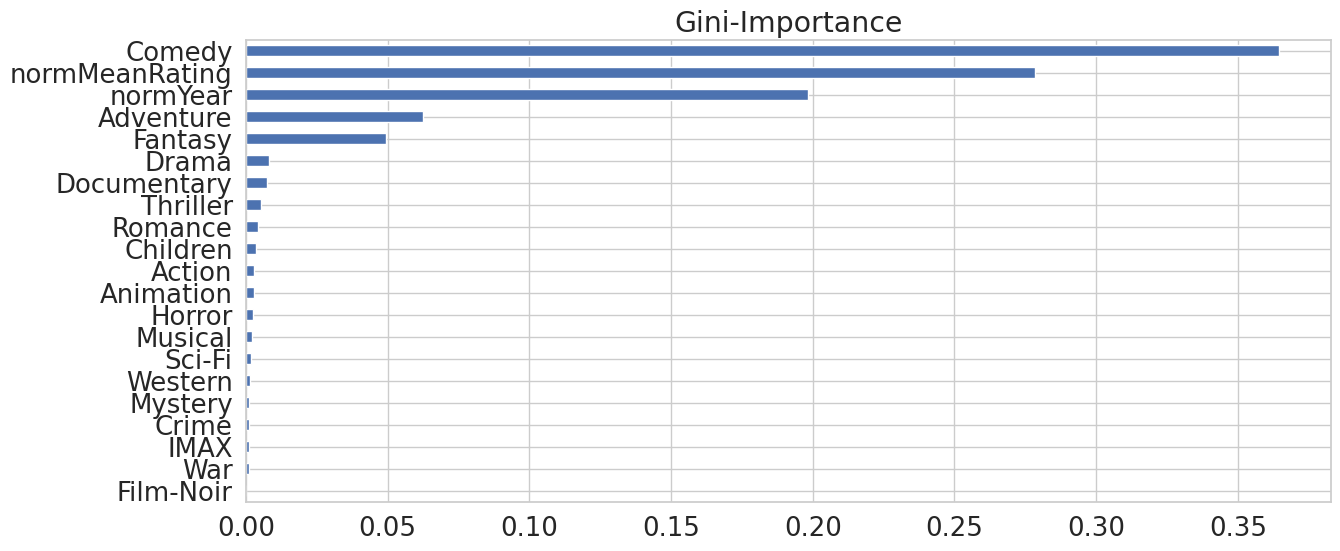

In [ ]:
u = copy.deepcopy(dffff)
for el in genre2code:
  if el != '(no genres listed)':
    u.rename(columns={genre2code[el]: el}, inplace=True)
  else:
    u.rename(columns={genre2code[el]: 'normYear'}, inplace=True)

u.rename(columns={20: 'normMeanRating'}, inplace=True)
u.columns = u.columns.astype(str)

feats = {}
for feature, importance in zip(u.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})

#display(importances)
importances.sort_values(by='Gini-Importance').plot(subplots=True,kind='barh', legend = 0, figsize=(14, 6), grid = 1)

***Модель Random Forest верно подметила, какие именно параметры были определяющими в том, понравится ли условному пользователю конкретный фильм.***

Напомним, что это были:

ЖАНР: "ADVENTURE"/"COMEDY"/"FANTASY",

ГОД: ПОСЛЕ 1983 ГОДА,

РЕЙТИНГ: БОЛЬШЕ 0.6
